In [1]:
from glob import glob 
from tqdm import tqdm_notebook,trange,tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras,cv2,os, gc
from sklearn.model_selection import train_test_split

from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPool2D
np.random.seed(42) 

Using TensorFlow backend.


## Chargement des données

In [2]:
test_path = "../input/test/"
df = pd.DataFrame({'path': glob(os.path.join("../input/train/",'*.tif'))})

In [3]:
df.head()

path
0  ../input/train/9dd758d956606454ae92ff95a538c1d...
1  ../input/train/4a7af151b3b65f8cb24351d1df6fc51...
2  ../input/train/c5e2d6be658f80396e54c502b68342c...
3  ../input/train/622387f8a409110fb4e382cbe886643...
4  ../input/train/d2464aec2d42b2b7d2b9b312b183988...

In [4]:
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])
df.head()

path                                        id
0  ../input/train/9dd758d956606454ae92ff95a538c1d...  9dd758d956606454ae92ff95a538c1de8be6bc3c
1  ../input/train/4a7af151b3b65f8cb24351d1df6fc51...  4a7af151b3b65f8cb24351d1df6fc5130ecbc934
2  ../input/train/c5e2d6be658f80396e54c502b68342c...  c5e2d6be658f80396e54c502b68342c66f9d4386
3  ../input/train/622387f8a409110fb4e382cbe886643...  622387f8a409110fb4e382cbe8866439ea2a71ce
4  ../input/train/d2464aec2d42b2b7d2b9b312b183988...  d2464aec2d42b2b7d2b9b312b18398848fd52066

In [5]:
labels = pd.read_csv("../input/train_labels.csv")
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [6]:
df = df.merge(labels, on = "id")
df.head()

path  ...  label
0  ../input/train/9dd758d956606454ae92ff95a538c1d...  ...      0
1  ../input/train/4a7af151b3b65f8cb24351d1df6fc51...  ...      0
2  ../input/train/c5e2d6be658f80396e54c502b68342c...  ...      0
3  ../input/train/622387f8a409110fb4e382cbe886643...  ...      0
4  ../input/train/d2464aec2d42b2b7d2b9b312b183988...  ...      0

[5 rows x 3 columns]

In [7]:
def load_data(start,end,df):
    l = end-start
    X = np.zeros([l,96,96,3],dtype=np.uint8) 
    y = df.label.values[start:end].reshape(-1)
    c=0
    for i in range(start,end):
        X[c] = cv2.imread(df["path"].values[i])
        c+=1
    return X,y

In [8]:
X,y = load_data(0,20,df=df)

## Visualisation des données

In [9]:
def show_samples(dat_f,l,diag):
    fig = plt.figure(figsize=(10, 4), dpi=150)
    for n,i in enumerate(l):
        ax = fig.add_subplot(2, 8//2, n+1, xticks=[], yticks=[])
        plt.imshow(dat_f[i])
        ax.set_title('Label: '+str(diag))

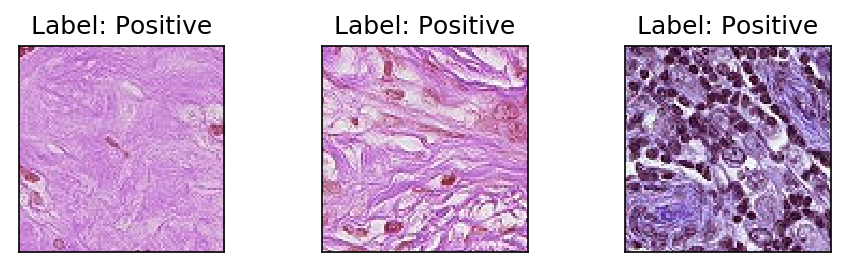

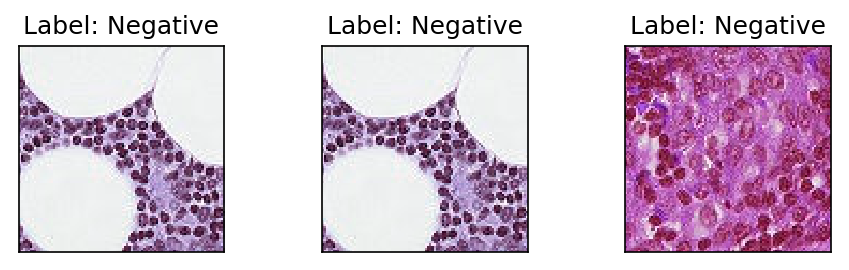

In [10]:
positive_samples = X[y == 1][:10]
negative_samples = X[y == 0][:10]
show_samples(positive_samples,np.random.randint(0,len(positive_samples),3),'Positive')
show_samples(negative_samples,np.random.randint(0,len(positive_samples),3),'Negative')
del positive_samples,negative_samples,X,y
gc.collect();

## Construction CNN

In [11]:
keras.backend.clear_session()
model = Sequential()

# Conv block 1
model.add(Conv2D(32, kernel_size=(3,3), input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(32, kernel_size=(3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4))

# Conv block 2
model.add(Conv2D(64, kernel_size=(3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, kernel_size=(3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.4))

# Conv block 3
model.add(Conv2D(128, kernel_size=(3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(128, kernel_size=(3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.4))

# FC layer
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.15,
        zoom_range=0.1)

earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
Nall = df.shape[0]
test_prop = 0.05
batch_size = 50
epochs = 20

for epoch in range(epochs):
    for switch in [1,0]:       
        if switch:
            X,y = load_data(0,110000,df=df)
        else:
            X,y = load_data(110000,Nall,df=df)
        N = y.shape[0]
        test_size = int(test_prop*N)    
        idx = np.arange(N)
        np.random.shuffle(idx)
        idx_train = idx[test_size:]
        idx_test = idx[:test_size]
        X_train,X_test,Y_train,Y_test = X[idx_train],X[idx_test],y[idx_train],y[idx_test]
        batch_nstep = np.floor((N-test_size)/batch_size).astype(int)
        batch_nstep_test = np.floor(test_size/batch_size).astype(int)
        loss,acc,losst,acct = 0,0,0,0
        with trange(batch_nstep) as t:
            for i in t:
                start_idx = i * batch_size
                x_batch = X_train[start_idx:start_idx+batch_size]/255.
                datagen.fit(x_batch)
                y_batch = Y_train[start_idx:start_idx+batch_size]
                metrics = model.fit_generator(datagen.flow(x_batch,y_batch,batch_size=batch_size),epochs = 1,verbose = 0, steps_per_epoch=1,
                                              callbacks=[reduce, earlystop])
                loss = loss + metrics.history['loss'][0]
                acc = acc + metrics.history['acc'][0]
                if switch:
                    t.set_description('- Start Epoch ' + str(epoch))
                else:
                    t.set_description('-  End  Epoch ' + str(epoch))
                t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
    with trange(batch_nstep_test) as t:
        for i in t:
            start_idx = i * batch_size
            x_batch = X_test[start_idx:start_idx+batch_size]/255.
            y_batch = Y_test[start_idx:start_idx+batch_size]
            metrics = model.test_on_batch(x_batch, y_batch)
            losst = losst + metrics[0]
            acct = acct + metrics[1]
            t.set_description('-> Running validation')
            t.set_postfix(loss="%.2f" % round(losst / (i+1),2),acc="%.2f" % round(acct / (i+1),2))
        
print("Validation loss:",losst / batch_nstep)
print("Validation accuracy:",acct / batch_nstep)
del X,y,X_train,X_test,Y_train,Y_test
gc.collect();

  0%|          | 0/2090 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
- Start Epoch 1:  27%|██▋       | 555/2090 [01:40<05:07,  4.99it/s, acc=0.87, loss=0.31]

In [14]:
test_files = glob(os.path.join( '../input/test/','*.tif'))
submission = pd.DataFrame()
batch = 5000
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread)
    K_test = np.stack(test_df["image"].values)/255.
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

Indexes: 0 - 5000
5000/5000 [==============================] - 2s 341us/step
Indexes: 5000 - 10000
5000/5000 [==============================] - 1s 289us/step
Indexes: 10000 - 15000
5000/5000 [==============================] - 1s 278us/step
Indexes: 15000 - 20000
5000/5000 [==============================] - 1s 262us/step
Indexes: 20000 - 25000
5000/5000 [==============================] - 1s 270us/step
Indexes: 25000 - 30000
5000/5000 [==============================] - 1s 262us/step
Indexes: 30000 - 35000
5000/5000 [==============================] - 1s 263us/step
Indexes: 35000 - 40000
5000/5000 [==============================] - 1s 269us/step
Indexes: 40000 - 45000
5000/5000 [==============================] - 1s 263us/step
Indexes: 45000 - 50000
5000/5000 [==============================] - 1s 262us/step
Indexes: 50000 - 55000
5000/5000 [==============================] - 1s 267us/step
Indexes: 55000 - 60000
2458/2458 [==============================] - 1s 287us/step


id     label
0  d3a0e75dd14a12773d7ad53bda6f1e1c5ba97f5c  0.132754
1  bdb69de941bb1dedf3d15564b39a67dec276f701  0.000167
2  371816c763c118a62ac1f4139f45806167c7e88b  0.000022
3  d18e5df26368164b4cd531941e489f2f19a5302d  0.098835
4  d57c22c04cd9c20540edff394de0f50fcdf55d0d  0.784905

In [15]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file